In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas

# Markov chains

## 10.2 Cambridge weather simulator

In [18]:
P = cambridge_weather_transitions = [[.2,.6,.2], [.3,0,.7], [0,.5,.5]]

def rweather(initial_state):
    x = initial_state
    while True:
        yield x
        x = np.random.choice(3, p=P[x])

x = rweather(initial_state=2) # x is an infinite-lazy-list object
for n in range(5): 
    print("On day", n, "weather is", next(x))

On day 0 weather is 2
On day 1 weather is 1
On day 2 weather is 0
On day 3 weather is 1
On day 4 weather is 2


## 10.2 Andrei Markov's trigram model

In [11]:
import urllib
import re
import collections

url = "http://norvig.com/ngrams/shakespeare.txt"
with urllib.request.urlopen(url) as f:
    txt = f.read().decode('utf8') 

# Clean up some spaces around punctuation etc.
txt = txt.lower()
txt = ' '.join(txt.split())
txt = re.sub(r'([a-z]) ([,:!?.;])', r'\1\2', txt)

# For every pair of characters, count the frequency of what comes next
next_char_count = collections.defaultdict(lambda: collections.defaultdict(int))
for i in range(len(txt)-3):
    u,v,w = txt[i:i+3]
    next_char_count[(u,v)][w] += 1

In [12]:
# Define a random NextCharacter function, based on counts
def rchar(u,v):
    chars = next_char_count[(u,v)].keys()
    counts = next_char_count[(u,v)].values()
    chars,counts = list(chars), np.array(list(counts))
    return np.random.choice(chars, p=counts/sum(counts))

# Repeatedly, look at the last two chars, randomly pick next
x = 'on'
for _ in range(200): x += rchar(x[-2], x[-1])

print(x)

ond frio, yeavoichis the boy thery eye? to bruse upost. theyearneand will; a parked down any a din bid for the com t's mathat prov'ret thy shaves ch on alim, arks, fairese th a but thall yourion rears. 


## 10.3 Multi-step transition probabilities

In [19]:
P = np.array(cambridge_weather_transitions)

In [20]:
# two-step transition probabilities
P @ P

array([[0.22, 0.22, 0.56],
       [0.06, 0.53, 0.41],
       [0.15, 0.25, 0.6 ]])

In [25]:
# 100-step transition probabilities
# Note: the probability you end up in state j converges to π_j, the stationary distribution, after very many steps
np.linalg.matrix_power(P, 100)

array([[0.12820513, 0.34188034, 0.52991453],
       [0.12820513, 0.34188034, 0.52991453],
       [0.12820513, 0.34188034, 0.52991453]])

## 10.3 Hitting probabilities
Random walk on a directed graph. State 5 is an absorbing state (i.e. once you get there you stay there). Let $\pi_x$ be the probability that, starting from state $x$, you hit state 0. (This is less than one, because you might get trapped in 5 before you hit 0.) The equations for hitting probability are ...

$$
\begin{align}
\pi_0 &= 1\\
\pi_5 &= 0\\
\pi_x &= \sum_y P_{x y} \pi_y = [P\pi]_x \quad\text{for }x=1,\dots,4
\end{align}
$$

In [26]:
# Adjacency matrix (including a link from state 5 back to itself)
E = np.array([[0,1,0,0,1,0],
              [1,0,0,0,1,1],
              [0,1,0,1,0,0],
              [0,0,1,0,1,1],
              [0,0,0,1,0,0],
              [0,0,0,0,0,1]])
# Transition matrix
P = E / E.sum(axis=1)[:,np.newaxis]
assert np.allclose(P.sum(axis=1), 1)

# Equations for hitting probability
Q = P.copy()
Q[0,:] = 0
Q[5,:] = 0
b = np.zeros(6)
b[0] = 1
π = np.linalg.solve(np.eye(6) - Q, b)
π

array([1.   , 0.375, 0.25 , 0.125, 0.125, 0.   ])

## 11.1 Stationary distribution

The stationary distribution solves
$$
\pi = \pi P \quad\text{and}\quad \pi\cdot1=1
$$
The first equation can be rewritten $\pi(P-I)=(P-I)^T\pi=0$.

In [28]:
P = np.array(cambridge_weather_transitions)
A = np.concatenate([(P-np.eye(3)).T, [[1,1,1]]])
π = np.linalg.lstsq(A, [0,0,0,1], rcond=None)[0]
π

array([0.12820513, 0.34188034, 0.52991453])

### Epidemic simulator

Model: $X_{n+1} = X_n + \operatorname{Poisson}(r X_n/d) - \operatorname{Bin}(X_n, 1/d)$

The Poisson term represents new infections, and the Binomial term represents recoveries or deaths.

In [44]:
def repidemic(x0,r=1.2,d=14,rng=None):
    x = x0
    while True:
        yield x
        x = x + rng.poisson(x*r/d) - rng.binomial(x, 1/d)

# Reproducibility setup: this will give me 5 simulation runs, the
# same 5 each time.
T = 5
rng = np.random.default_rng(1618)
seeds = rng.integers(1000, size=T)

# Run them each for 2000 timesteps
H = 2000
xs = [repidemic(5, r=1.2, d=14, rng=np.random.default_rng(s)) for s in seeds]
xs = [[next(r) for _ in range(H)] for r in xs]

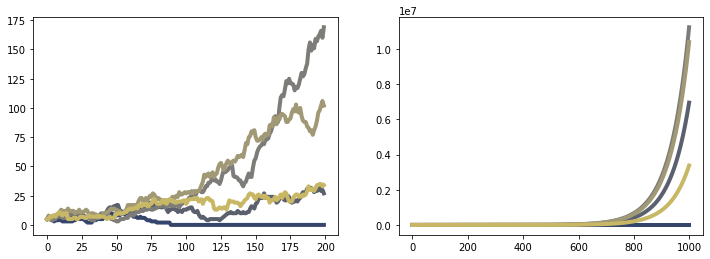

In [46]:
fig,axes = plt.subplots(1,2, figsize=(12,4))
cmap = plt.get_cmap('cividis')
cols = [cmap(c) for c in np.linspace(.2,.8,T)]

for n,ax in zip([200,1000],axes):
    for x,c in zip(xs, cols):
        ax.plot(np.arange(n), x[:n], color=c, linewidth=4)
        
plt.show()

### Active Users simulator

Model: $X_{n+1} = X_n + \operatorname{Poisson}(\lambda) - \operatorname{Bin}(X_n, 1/d)$

The Poisson term represents newly arrived users, and the Binomial term represents departures.

In [53]:
def rusers(x0,λ,d,rng=None):
    x = x0
    while True:
        yield x
        x = x + rng.poisson(λ) - rng.binomial(x, 1/d)

# Reproducibility setup
T = 2
rng = np.random.default_rng(1618)
seeds = rng.integers(1000, size=T)

# Run them each for 2000 timesteps
H = 2000
xs = [rusers(5, λ=1.2, d=14, rng=np.random.default_rng(s)) for s in seeds]
xs = [[next(r) for _ in range(H)] for r in xs]

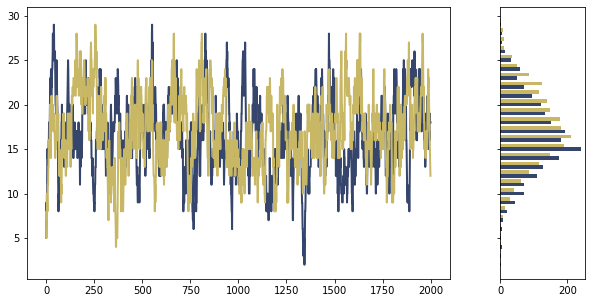

In [57]:
fig,(ax,ax2) = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios':[1,.2]}, sharey=True)
cmap = plt.get_cmap('cividis')
cols = [cmap(c) for c in np.linspace(.2,.8,T)]

for i,(x,c) in enumerate(zip(xs, cols)):
    ax.plot(np.arange(H), x, color=c, linewidth=2)
    counts = pandas.Series(x).value_counts()
    ax2.barh(counts.index+0.8*i/T, counts.values, color=c, height=0.8/T)

plt.show()